# Cyber Data Analytics, CS4035
## Lab assignment 1: Fraud detection
### April 2019

### Importing data from CSV file

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

data = pd.read_csv('./data_for_student_case.csv', sep = ',')
data = data.dropna()

data = data[data['simple_journal'] != 'Refused']

# print(data.dtypes)

labels = data['simple_journal']
print("Number of non-fraud: ", np.sum(labels == 'Settled'), ", with ratio: ", np.sum(labels == 'Settled')/len(labels))
print("Number of fraud: ", np.sum(labels == 'Chargeback'), ", with ratio: ", np.sum(labels == 'Chargeback')/len(labels))
print("Number refused: ", np.sum(labels == 'Refused'), ", with ratio: ", np.sum(labels == 'Refused')/len(labels))

data.groupby(by = 'simple_journal').count()

Number of non-fraud:  223165 , with ratio:  0.9984564449017941
Number of fraud:  345 , with ratio:  0.0015435550982058968
Number refused:  0 , with ratio:  0.0


,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
simple_journal,,,,,,,,,,,,,,,,
Chargeback,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345,345
Settled,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165,223165


## Convesion of categorical data to numeric

In [6]:
data_cat = data.copy(True)

data_oneHot = pd.get_dummies(data, columns = ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode', 'shopperinteraction', 'cardverificationcodesupplied', 'accountcode'])

label_mapping = {}

# Convert currency code in order to 'amount' in a single code
label_mapping['currencycode'] = {'SEK': 0.09703, 'MXN': 0.04358, 'AUD': 0.63161, 'NZD': 0.58377, 'GBP':1.13355} 
data.replace({'currencycode' : label_mapping['currencycode']}, inplace=True)
data['amount'] = data['amount'] * data['currencycode']

label_mapping['simple_journal'] = {'Settled': 0, 'Chargeback' : 1}
data.replace({'simple_journal' : label_mapping['simple_journal']}, inplace=True)

# Convert all the rest columns which are of type 'object'
char_cols = data.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    data[c], label_mapping[c] = pd.factorize(data[c])

label_mapping

{'currencycode': {'SEK': 0.09703,
  'MXN': 0.04358,
  'AUD': 0.63161,
  'NZD': 0.58377,
  'GBP': 1.13355},
 'simple_journal': {'Settled': 0, 'Chargeback': 1},
 'bookingdate': Index(['2015-11-09 14:26:51', '2015-11-09 14:27:38', '2015-11-23 16:34:16',
        '2015-11-23 16:34:51', '2015-11-09 14:26:08', '2015-11-09 14:26:25',
        '2015-11-09 14:26:47', '2015-11-23 16:34:29', '2015-12-08 19:58:35',
        '2015-11-09 14:25:50',
        ...
        '2015-11-03 08:12:13', '2015-11-03 08:12:14', '2015-11-03 22:33:58',
        '2015-11-03 18:57:00', '2015-11-02 20:34:44', '2015-11-02 20:34:30',
        '2015-10-31 20:04:21', '2015-10-31 22:03:39', '2015-11-02 20:16:57',
        '2015-11-03 18:57:01'],
       dtype='object', length=39902),
 'issuercountrycode': Index(['MX', 'SA', 'CA', 'AR', 'CL', 'CO', 'FR', 'US', 'JP', 'AE',
        ...
        'BB', 'CW', 'AZ', 'AM', 'DO', 'AI', 'MN', 'TM', 'BZ', 'ME'],
       dtype='object', length=115),
 'txvariantcode': Index(['mccredit', 'visacla

### HeatMap

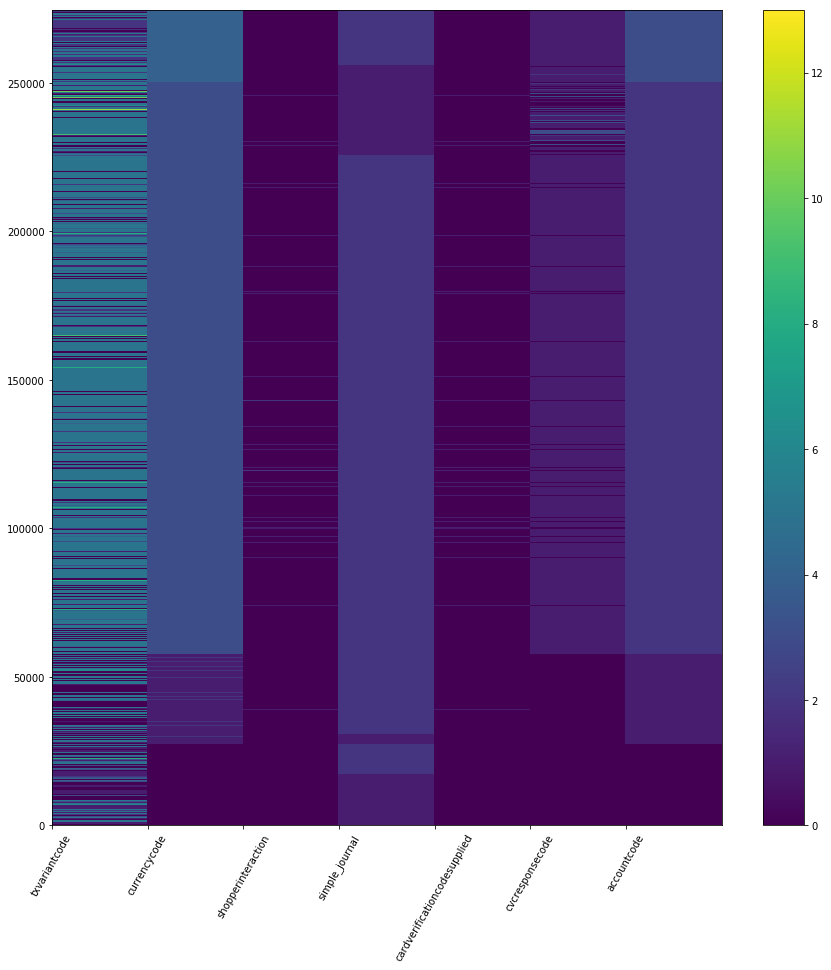

In [33]:
labels = ['txvariantcode', 'currencycode', 'shopperinteraction', 'simple_journal',  
          'cardverificationcodesupplied', 'cvcresponsecode', 'accountcode']

plt.figure(figsize = (15,15))
plt.pcolor(data[labels])
plt.xticks(np.arange(len(labels)), labels, rotation = 60)
plt.colorbar()

### Aggregated values per card id

(223071, 6)


Text(0.5, 1.0, 'Fraud')

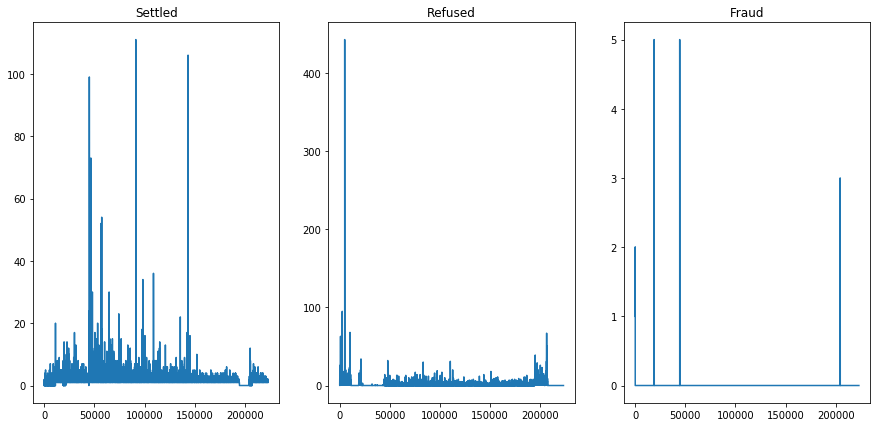

In [32]:
data_agg = data_cat[['card_id', 'simple_journal', 'amount']]

dd = pd.get_dummies(data_agg, columns = ['simple_journal'])

dd['sum_fraud'] = dd['amount'] * dd['simple_journal_Chargeback']
dd['sum_ref'] = dd['amount'] * dd['simple_journal_Refused']
dd['sum_OK'] = dd['amount'] * dd['simple_journal_Settled']

dd_user = dd.groupby(by = 'card_id', sort = False).agg({
    'simple_journal_Settled' : sum,
    'sum_OK' : 'mean',
    'simple_journal_Refused' : sum,
    'sum_ref' : 'mean',
    'simple_journal_Chargeback' : sum,
    'sum_fraud' : 'mean'
})

print(dd_user.values.shape)

# Visualizations
f, ax = plt.subplots(1, 3, figsize = (15,7))
ax[0].plot(dd_user.values[:, 0])
ax[0].set_title("Settled")
ax[1].plot(dd_user.values[:, 2])
ax[1].set_title("Refused")
ax[2].plot(dd_user.values[:, 4])
ax[2].set_title("Fraud")

In [43]:
test = data['bookingdate'].str.extract('(....-..-..)', expand=True)
test
tt = test[0].unique().sort()


None


### Visualizations

Text(0, 0.5, 'mean amount per group')

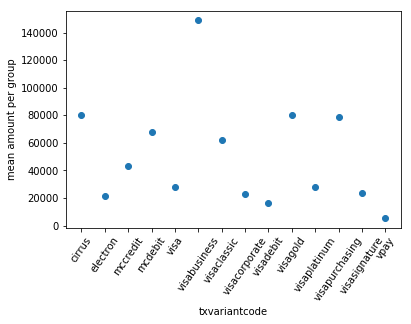

In [35]:
code = data_cat[['txvariantcode', 'amount']].groupby(['txvariantcode']).mean()
code.values
labels = code.index.values
plt.scatter(np.arange(len(code.values)), code.values)
plt.xticks(np.arange(len(code.values)), labels, rotation = '55')
plt.xlabel('txvariantcode')
plt.ylabel('mean amount per group')

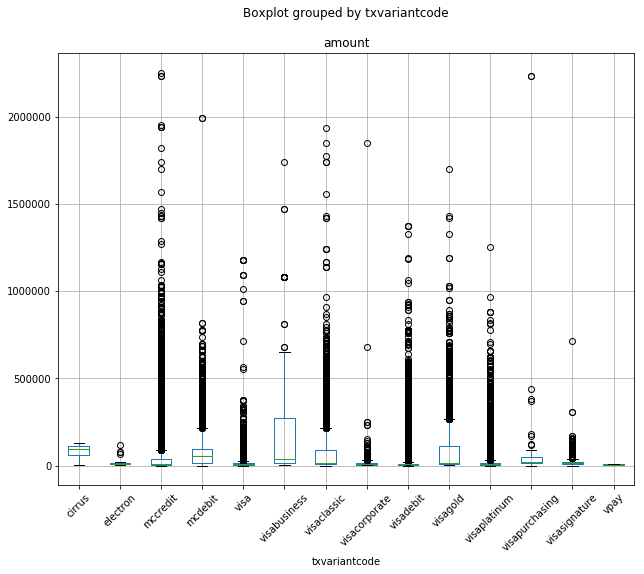

In [36]:
data_cat.boxplot(column = 'amount', by = 'txvariantcode', figsize = (10, 8), rot = '45')

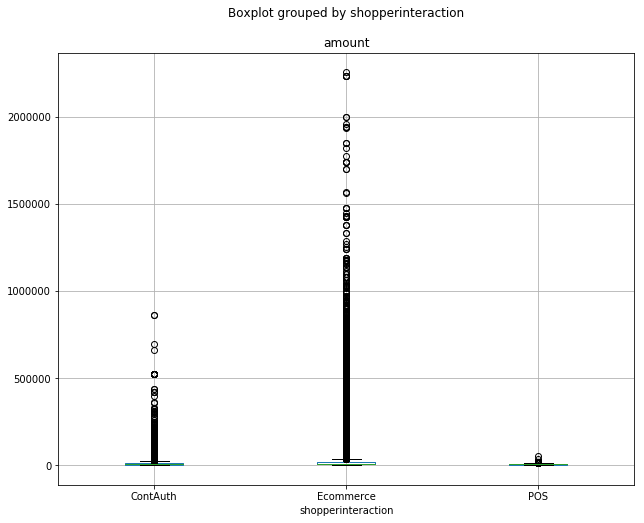

In [38]:
data_cat.boxplot(column = ['amount'], by = 'shopperinteraction', figsize = (10,8))

### Number of IP addresses per card id
#### The more addresses the more suspicious the transactions are

In [40]:
data_cat[['card_id', 'ip_id']].groupby('card_id').nunique().sort_values(by = 'ip_id', ascending = False).head()

,card_id,ip_id
card_id,,
card267365,1,25
card183189,1,25
card11998,1,23
card210128,1,22
card18592,1,20


## Classification

In [7]:
from PlotConfusionMatrix import *
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from RocAnalysis import *

X = data.drop(['simple_journal', 'creationdate', 'bookingdate', 'currencycode'], axis = 1).values
y = data['simple_journal'].values

# # Imputing missing values.. we could alternatively just remove these samples
# imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# print(np.sum(np.isnan(X)))
# X = imp.fit_transform(X)

# imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
# X = imp.fit_transform(X)

print("Fraud class samples: ", np.sum(y == 1))
print("Non-fraud class samples: ", np.sum(y == 0))
print("Ratio: ", np.sum(y == 1)/np.sum(y == 0))

# 10-Fold cross validation used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

Fraud class samples:  345
Non-fraud class samples:  223165
Ratio:  0.0015459413438487217


21165 1152 9 26
21213 1104 13 22
21154 1163 12 23
21167 1150 12 23
21127 1190 16 19
21137 1179 14 20
21118 1198 7 27
21168 1148 15 19
21157 1159 16 18
21189 1127 14 20


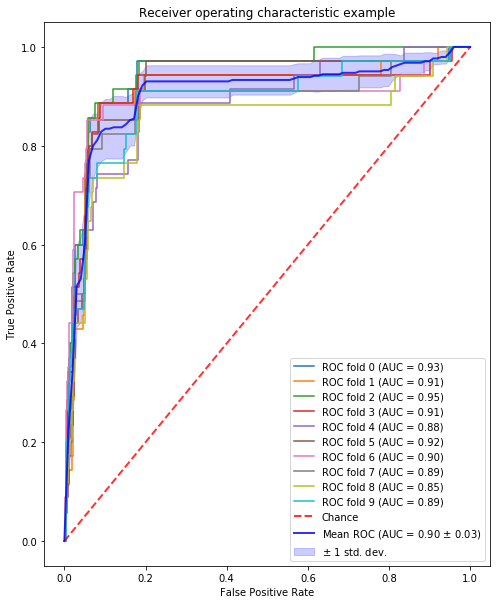

Confusion matrix, without normalization
[[211595  11570]
 [   128    217]]


<Figure size 432x288 with 0 Axes>

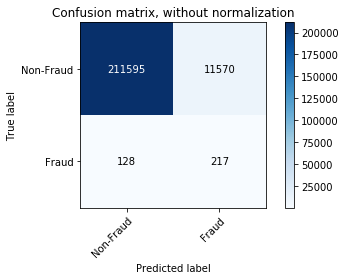

In [8]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

20938 1379 7 28
20880 1437 9 26
20816 1501 7 28
20919 1398 5 30
20801 1516 7 28
21028 1288 10 24
20820 1496 6 28
20846 1470 7 27
20935 1381 6 28
20947 1369 11 23


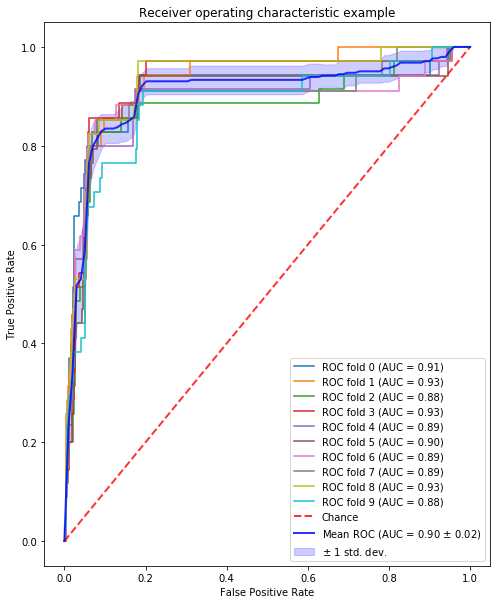

Confusion matrix, without normalization
[[208930  14235]
 [    75    270]]


<Figure size 432x288 with 0 Axes>

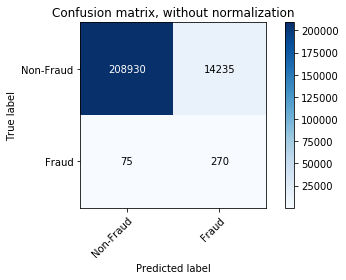

In [9]:
# Modifying class priors for GaussianNB
clf = GaussianNB(priors = [0.99, 0.01])
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

22317 0 35 0
22312 5 35 0
22315 2 35 0
22317 0 35 0
22317 0 35 0
22315 1 34 0
22316 0 34 0
22316 0 34 0
22315 1 34 0
22316 0 34 0


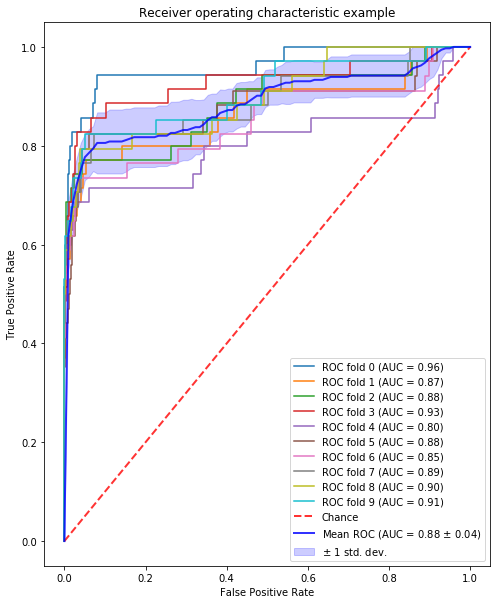

Confusion matrix, without normalization
[[223156      9]
 [   345      0]]


<Figure size 432x288 with 0 Axes>

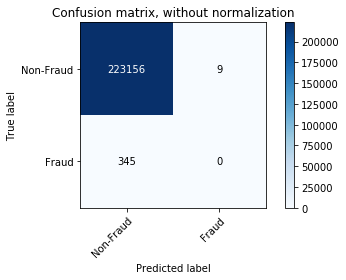

In [10]:
from  sklearn.linear_model import LogisticRegression as LR


clf = LR(solver = 'lbfgs', multi_class = 'auto')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

28616 388 27 8
28645 359 30 5
28627 377 29 6
28644 360 29 6
28624 380 27 8
28624 380 23 11
28655 349 30 4
28676 327 28 6
28644 359 27 7


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


28603 400 27 7


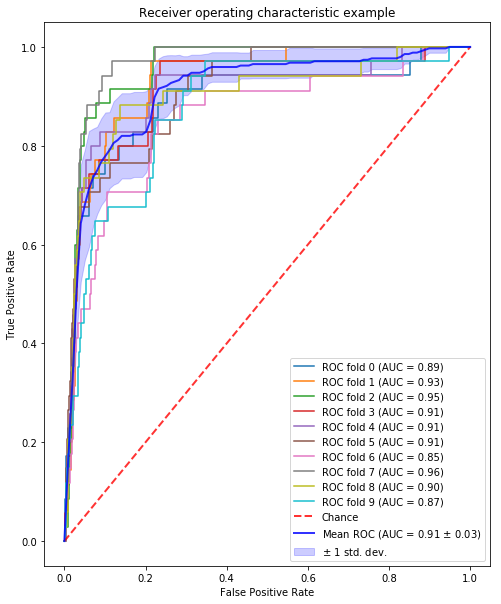

Confusion matrix, without normalization
[[286358   3679]
 [   277     68]]


<Figure size 432x288 with 0 Axes>

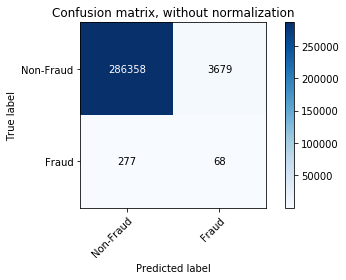

In [10]:
# assigning different class weights
clf = LR(solver = 'lbfgs', multi_class = 'auto', class_weight={0:1, 1:100})
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22317 0 1 34
22317 0 1 34
22316 1 0 35
22317 0 1 34
22317 0 0 35
22316 0 1 33
22316 0 0 34
22316 0 1 33
22316 0 0 34
22316 0 0 34


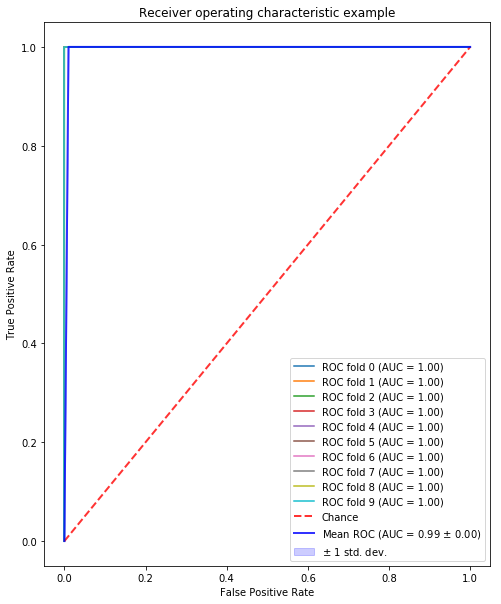

Confusion matrix, without normalization
[[223164      1]
 [     5    340]]


<Figure size 432x288 with 0 Axes>

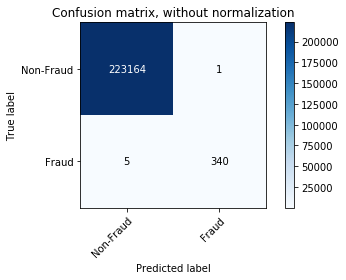

In [11]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

22257 60 33 2
22272 45 34 1
22279 38 34 1
22263 54 32 3
22273 44 32 3
22264 52 33 1
22252 64 32 2
22261 55 34 0
22269 47 32 2
22279 37 34 0


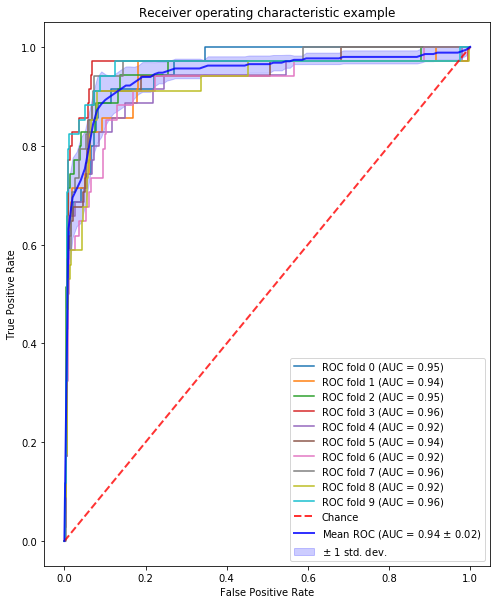

Confusion matrix, without normalization
[[222669    496]
 [   330     15]]


<Figure size 432x288 with 0 Axes>

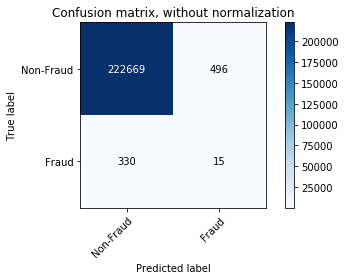

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA(solver='svd')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


21728 589 0 35
21767 550 1 34


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


21918 399 3 32
22200 117 27 8


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


21921 396 3 32
21954 362 5 29


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


21660 656 0 34
21764 552 6 28


/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


21675 641 0 34
21710 606 2 32


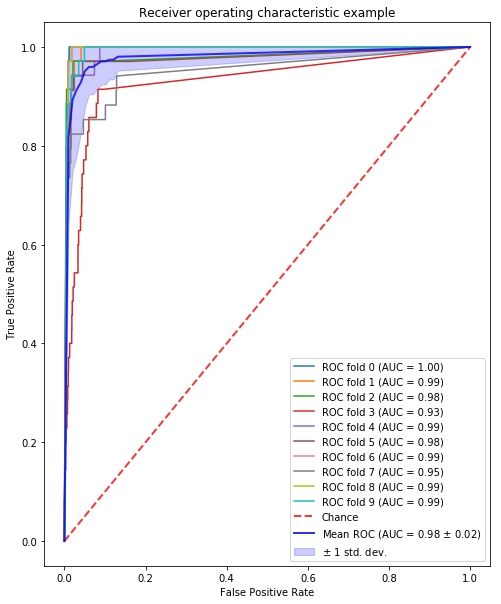

Confusion matrix, without normalization
[[218297   4868]
 [    47    298]]


<Figure size 432x288 with 0 Axes>

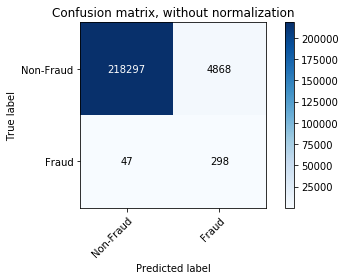

In [13]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

clf = QDA()
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = KNN(n_neighbors=5, weights='distance', algorithm='auto', leaf_size=30, p=2, metric='minkowski', n_jobs=-1)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

29003 1 1 34
29004 0 0 35
29004 0 0 35
29004 0 0 35
29004 0 0 35
29004 0 1 33
29004 0 0 34
29003 0 1 33
29003 0 0 34
29003 0 1 33


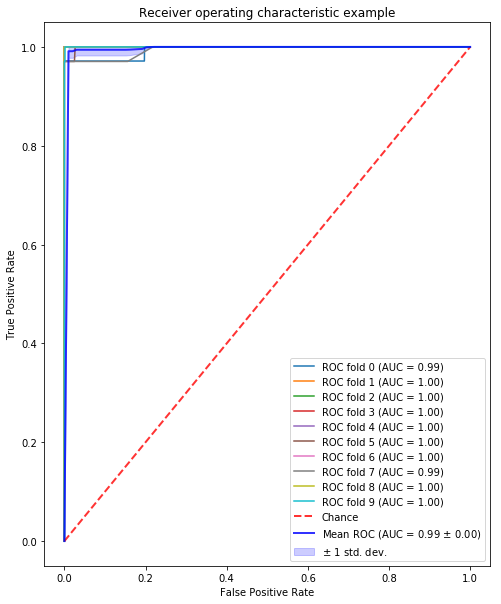

Confusion matrix, without normalization
[[290036      1]
 [     4    341]]


<Figure size 432x288 with 0 Axes>

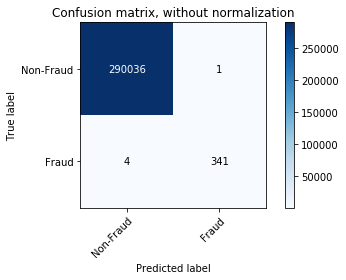

In [14]:
from sklearn.ensemble import AdaBoostClassifier as AdaBoost

clf = AdaBoost(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R')
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

### Dimensionality Reduction & Scaling

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as StandardScaler

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

pca = PCA(n_components=0.95, whiten = True)
X_pca = pca.fit_transform(X_scaled)
pca.n_components_

7

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
m_tpr, std_tpr, m_auc, std_auc, cm = roc_analysis(X, y, clf, cv, True, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22317 0 1 34
22317 0 1 34
22317 0 0 35
